## Part 1: Imports & Load data

In [86]:
#data science
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

#general
import zipfile
import datetime as dt

In [3]:
#unzip the files
# with zipfile.ZipFile("../data/jpx-tokyo-stock-exchange-prediction.zip","r") as zip_ref:
#     zip_ref.extractall("../data")

In [300]:
company_info = pd.read_csv('../data/stock_list.csv',low_memory=False)
financials = pd.read_csv('../data/train_files/financials.csv',low_memory=False)
options = pd.read_csv('../data/train_files/options.csv',low_memory=False)
stock_prices = pd.read_csv('../data/train_files/stock_prices.csv',low_memory=False)
secondary_stock_prices = pd.read_csv('../data/train_files/secondary_stock_prices.csv',low_memory=False)
trades = pd.read_csv('../data/train_files/trades.csv',low_memory=False)

## Part 2: EDA

In [13]:
stocks = stock_prices['SecuritiesCode'].unique().tolist()
print(f'{len(stocks)} JPX stocks available')

2000 JPX stocks available


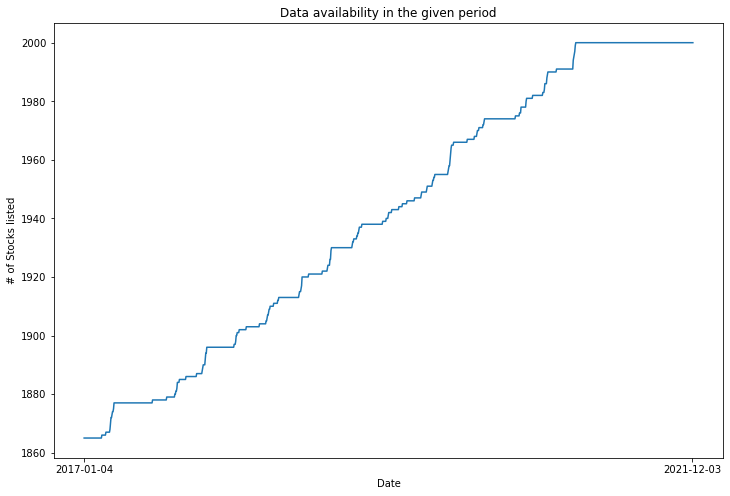

In [166]:
dates = stock_prices.groupby('Date').count().index.tolist()
num_listed = stock_prices.groupby('Date').count()['RowId'].values.tolist()

plt.figure(figsize=[12,8])
plt.plot(num_listed)
plt.xticks([0,1200],[dates[0],dates[-1]])
plt.xlabel('Date')
plt.ylabel('# of Stocks listed')
plt.title('Data availability in the given period')
plt.show()

In [79]:
start_df = stock_prices[stock_prices['Date']==dates[0]][['SecuritiesCode','Close']].set_index('SecuritiesCode')
end_df = stock_prices[(stock_prices['Date']==dates[-1])][['SecuritiesCode','Close']].set_index('SecuritiesCode')

stocks_from_start = end_df.index.intersection(start_df.index)
stocks_from_start_change = (((end_df.loc[stocks_from_start]-start_df.loc[stocks_from_start])/start_df.loc[stocks_from_start])*100).sort_values(by='Close',ascending=False)

In [167]:
print(f'{stocks_from_start_change.shape[0]} companies were listed from {dates[0]} to {dates[-1]}')
print(f'{(stocks_from_start_change>0).sum()[0]} stocks went UP in that period, {(stocks_from_start_change<=0).sum()[0]} went DOWN')
print(f'{(stocks_from_start_change>0).mean()[0]:.2f}% was the average percentage change in stock price across {stocks_from_start_change.shape[0]} companies')

1865 companies were listed from 2017-01-04 to 2021-12-03
1065 stocks went UP in that period, 793 went DOWN
0.57% was the average percentage change in stock price across 1865 companies


## Part 3: Split data

## Part 4: Create baseline

<b>Goal 1: Predict Target returns</b>
<br>
<b>Goal 2: Think about minimal volatility</b>

### Sample submission

In [286]:
sample_submission = pd.read_csv('../data/example_test_files/sample_submission.csv')

### Define competition metric

In [261]:
def calc_spread_return_sharpe(df,portfolio_size=200,toprank_weight_ratio=2):
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        df['Rank'] = np.arange(0,2000,1)
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

### Baseline 1: Winners - Win, Loosers - Lose

<p>Predictions need to be submitted by <b>July 5, 2022</b>, and <b>October 7, 2022</b> is the end of competition. Hence, we can backtest our prediction by going back the same number of working days from the last date available in the dataset</p>

In [95]:
start_comp = dt.date(2022,7,5)
end_comp = dt.date(2022,10,7)

working_days = np.busday_count(start_comp,end_comp)
print(f'{working_days} is the number of working days between July 5, 2022 and October 7, 2022')

68 is the number of working days between July 5, 2022 and October 7, 2022


In [119]:
start_test = dt.date(2021,8,31)
end_test = dates[-1].split('-')

print(f'{np.busday_count(start_test,dt.date(int(end_test[0]),int(end_test[1]),int(end_test[2])))} working days between August 31, 2021 and December 3, 2021')

68 working days between August 31, 2021 and December 3, 2021


In [122]:
start_test_df = stock_prices[stock_prices['Date']=='2021-08-31'].set_index('SecuritiesCode')[['Close']]
end_test_df = stock_prices[stock_prices['Date']==dates[-1]].set_index('SecuritiesCode')[['Close']]

In [134]:
stocks_to_test = stocks_from_start.intersection(start_test_df.index)

In [168]:
stocks_to_long = ((start_test_df.loc[stocks_to_test]-start_df)/start_df).sort_values(by='Close',ascending=False).head(200).index
stocks_to_short = ((start_test_df.loc[stocks_to_test]-start_df)/start_df).sort_values(by='Close',ascending=False).dropna().tail(200).index

In [169]:
#long returns
((end_test_df.loc[stocks_to_long]-start_test_df.loc[stocks_to_long])/start_test_df.loc[stocks_to_long]).sort_values(by='Close',ascending=False).mean()

Close   -0.048387
dtype: float64

In [164]:
-((end_test_df.loc[stocks_to_short]-start_test_df.loc[stocks_to_short])/start_test_df.loc[stocks_to_short]).sort_values(by='Close',ascending=False).mean()

Close    0.050868
dtype: float64

## Part 5: Feature engineering

### Price data

In [296]:
stock_prices['Close-Open'] = (stock_prices['Close']-stock_prices['Open'])/(stock_prices['Open'])

### Financials + General company info

<b>Ideas:</b>

<ul>
    <li>Impact of being a part of an index?</li>
    <li>Impact of industry? Inter-industry performance? Assign weights to industries to account for risk?</li>
    <li>Impact of market segment?</li>
    <li>Market capitalisation as a factor?</li>
</ul>

In [318]:
all_available_companies = end_df.index

In [324]:
company_info = company_info[['SecuritiesCode','NewMarketSegment','MarketCapitalization','33SectorName']].set_index('SecuritiesCode')

In [326]:
company_info_short = company_info.loc[all_available_companies]

In [328]:
company_info_short.sort_values(by='MarketCapitalization',ascending=False)

,NewMarketSegment,MarketCapitalization,33SectorName
SecuritiesCode,,,
7203,Prime Market,3.435121e+13,Transportation Equipment
6758,Prime Market,1.825416e+13,Electric Appliances
6861,Prime Market,1.757905e+13,Electric Appliances
6098,Prime Market,1.182423e+13,Services
9432,Prime Market,1.140934e+13,Information & Communication
...,...,...,...
8338,Prime Market,1.461201e+10,Banks
4847,Prime Market,1.459236e+10,Information & Communication
6769,Standard Market,1.458600e+10,Electric Appliances


In [331]:
company_info_short.reset_index(inplace=True)

In [333]:
company_info_short

,SecuritiesCode,NewMarketSegment,MarketCapitalization,33SectorName
0,6539,Prime Market,2.311186e+10,Services
1,3157,Standard Market,1.522636e+10,Wholesale Trade
2,4507,Prime Market,2.531638e+12,Pharmaceutical
3,6769,Standard Market,1.458600e+10,Electric Appliances
4,8198,Standard Market,1.006678e+11,Retail Trade
...,...,...,...,...
1995,5741,Prime Market,1.285047e+11,Nonferrous Metals
1996,7956,Prime Market,2.673944e+11,Other Products
1997,6035,Prime Market,1.225588e+11,Services
1998,6082,Prime Market,1.797430e+10,Services
